<a href="https://colab.research.google.com/github/Shivachikkonda02/-Bank-Marketing-Analysis-and-Classification-ML-Project/blob/main/Time%20Series%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import streamlit as st
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [49]:
# 1. Load Data
df1 = pd.read_csv('/content/Transactional_data_retail_0101.csv')
df2 = pd.read_csv('/content/Transactional_data_retail_0202.csv')
customer_demo = pd.read_csv('/content/CustomerDemographics.csv')
product_info = pd.read_csv('/content/ProductInfo.csv')

In [50]:
# Concatenate df1 and df2
df = pd.concat([df1, df2])

In [51]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y')

In [52]:
# Merge Data
df = df.merge(customer_demo, on='Customer ID', how='left')
df = df.merge(product_info, on='StockCode', how='left')

In [53]:
# 2. Data Cleaning and Preprocessing
df.dropna(inplace=True)  # Drop missing values

In [54]:
# Checking null values
df.isna().sum()

,0
Invoice,0
StockCode,0
Quantity,0
Price,0
Customer ID,0
InvoiceDate,0
Country,0
Description,0


In [55]:
 # Calculate total price
df['TotalPrice'] = df['Quantity'] * df['Price']

In [56]:
# 3. EDA - Visualizations
# Customer-Level Summary
customer_summary = df.groupby('Customer ID').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'Invoice': 'nunique'
}).reset_index()

In [57]:
customer_summary.head()

,Customer ID,Quantity,TotalPrice,Invoice
0,12362.0,3476,8128.59,14
1,12431.0,8934,20879.07,33
2,12583.0,13502,22578.02,31
3,12636.0,1,141.00,1
4,12682.0,23399,50612.92,53


In [58]:
# Item-Level Summary
item_summary = df.groupby('StockCode').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'Invoice': 'nunique'
}).reset_index()

In [27]:
item_summary.head()

,StockCode,Quantity,TotalPrice,Invoice
0,10002,471,400.35,21
1,10080,2,1.70,1
2,10120,14,2.94,2
3,10123C,2,1.30,2
4,10123G,1,0.65,1


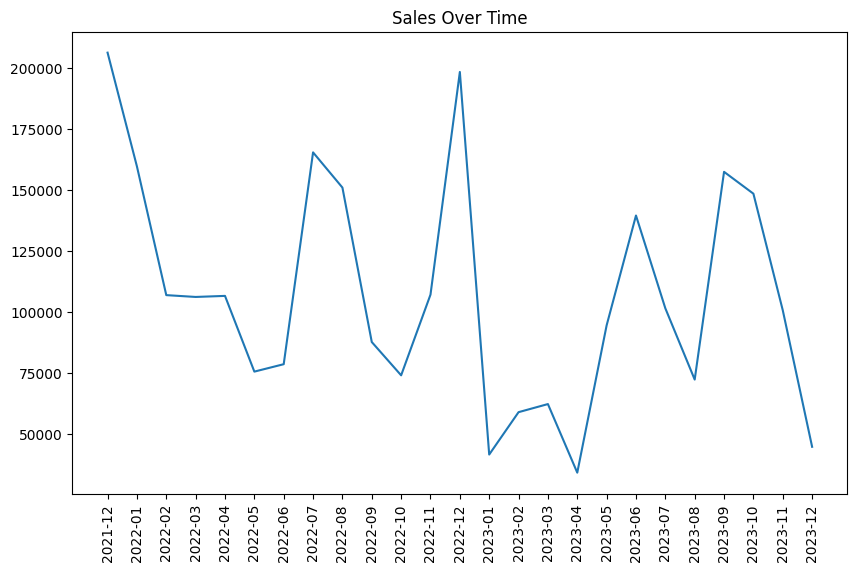

In [59]:
# Plot sales over time
sales_time = df.groupby(df['InvoiceDate'].dt.to_period('M')).agg({'TotalPrice': 'sum'}).reset_index()

plt.figure(figsize=(10,6))
plt.plot(sales_time['InvoiceDate'].astype(str), sales_time['TotalPrice'])
plt.title('Sales Over Time')
plt.xticks(rotation=90)
plt.show()

In [60]:
# 4. Top 10 Stock Codes by Quantity and Revenue
top_10_quantity = df.groupby('StockCode')['Quantity'].sum().nlargest(10).index
top_10_revenue = df.groupby('StockCode')['TotalPrice'].sum().nlargest(10).index

In [61]:
top_10_quantity

Index(['85099B', '85123A', '21181', '84879', '22197', '20713', '23084',
       '21523', '22189', '22386'],
      dtype='object', name='StockCode')

In [62]:
top_10_revenue

Index(['85123A', '22423', '85099B', '21523', '48173C', '48188', '21955',
       '20685', '21181', '21623'],
      dtype='object', name='StockCode')

In [63]:
# 5. Time Series Analysis for Top 10 Products
# Forecasting with ARIMA for one of the top 10 products
stock_code = top_10_quantity[0]  # Example product
df_stock = df[df['StockCode'] == stock_code]

In [64]:
# Resample by week
df_stock = df_stock.set_index('InvoiceDate').resample('W').agg({'Quantity': 'sum'})


In [65]:
# Split data into train/test
train = df_stock.iloc[:-15]
test = df_stock.iloc[-15:]

In [66]:
# Build ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))
arima_result = arima_model.fit()


In [68]:
# 5b. Exponential Smoothing (ETS)
# Assuming at least 8 months of data and setting to monthly seasonality
ets_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=4).fit()

In [69]:
# 5c. Prophet Model
prophet_df = train.reset_index().rename(columns={'InvoiceDate': 'ds', 'Quantity': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=15, freq='W')
prophet_forecast = prophet_model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw2yhvtpf/qmbi0jhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw2yhvtpf/607tqbve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63658', 'data', 'file=/tmp/tmpw2yhvtpf/qmbi0jhu.json', 'init=/tmp/tmpw2yhvtpf/607tqbve.json', 'output', 'file=/tmp/tmpw2yhvtpf/prophet_modeliu9mib4t/prophet_model-20241005034426.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:44:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:44:26 - cmdstanpy - INFO - Chai

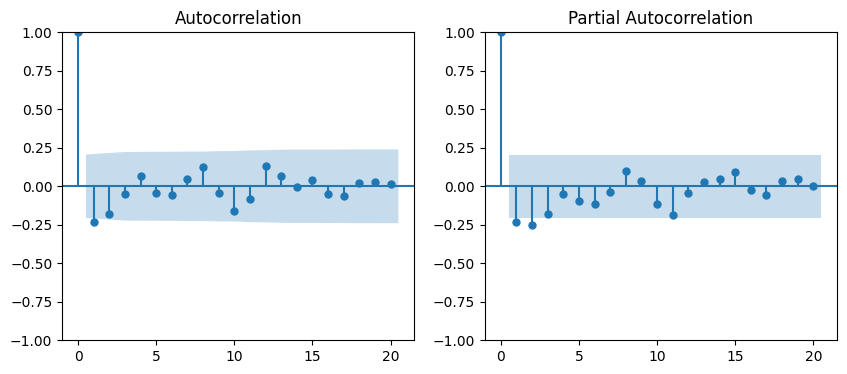

In [70]:
# ACF and PACF plots
plt.figure(figsize=(10, 4))
plot_acf(train, ax=plt.subplot(121))
plot_pacf(train, ax=plt.subplot(122))
plt.show()

In [72]:
# Forecast with ARIMA
arima_forecast = arima_result.forecast(steps=15)

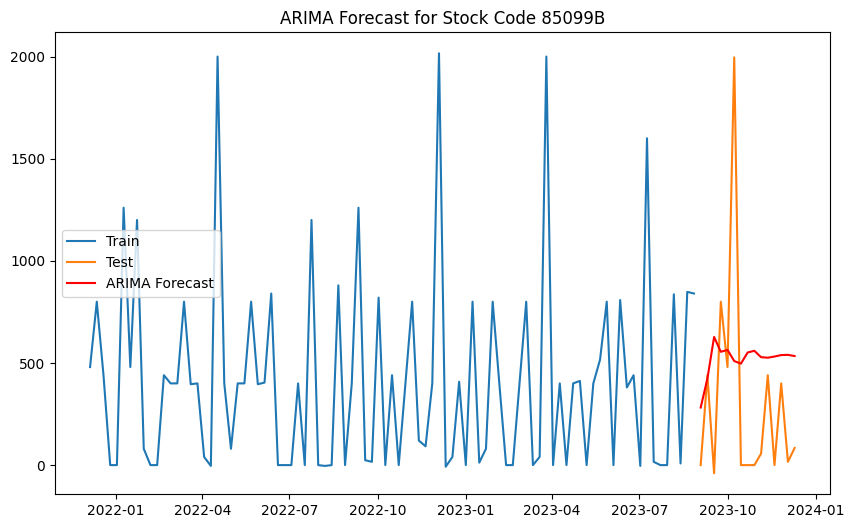

In [73]:
# Plot historical vs forecasted (ARIMA)
plt.figure(figsize=(10,6))
plt.plot(train.index, train['Quantity'], label='Train')
plt.plot(test.index, test['Quantity'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title(f'ARIMA Forecast for Stock Code {stock_code}')
plt.show()

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


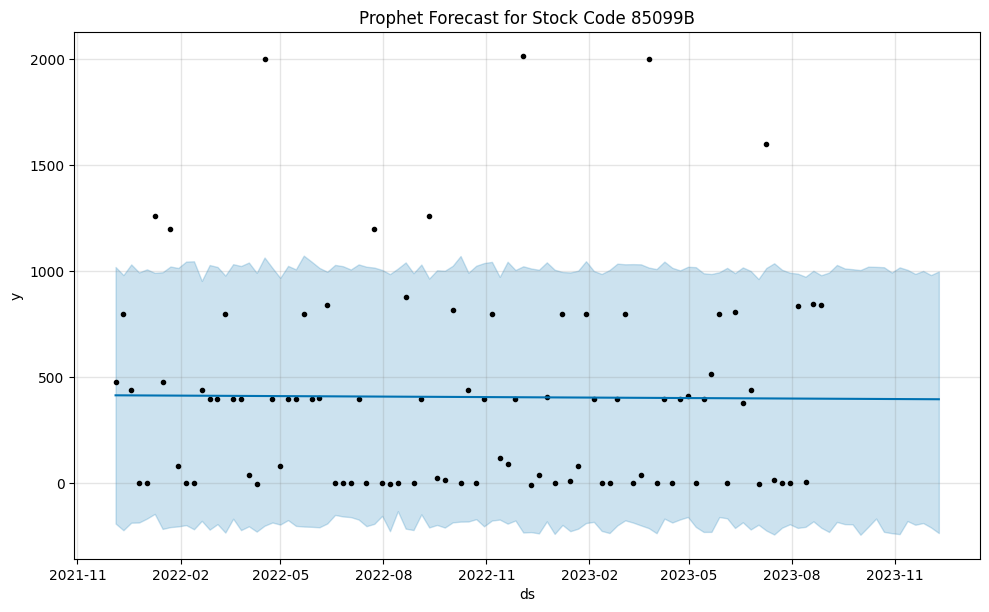

In [74]:
# Plot Prophet Forecast
prophet_fig = prophet_model.plot(prophet_forecast)
plt.title(f'Prophet Forecast for Stock Code {stock_code}')
plt.show()

In [75]:
# 6. Non-Time Series Model (Decision Tree using Customer/Item Features)
features = df[['Quantity', 'Price', 'Country', 'StockCode']]
features = pd.get_dummies(features, columns=['Country', 'StockCode'])

target = df['Quantity']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)


DecisionTreeRegressor()

In [76]:
# Predictions
tree_predictions = tree_model.predict(X_test)

In [77]:
# Evaluation Metrics for Decision Tree
rmse = np.sqrt(mean_squared_error(y_test, tree_predictions))
mae = mean_absolute_error(y_test, tree_predictions)

In [78]:
print(f'Decision Tree RMSE: {rmse}, MAE: {mae}')

Decision Tree RMSE: 15.365285142587082, MAE: 0.16129032258064516


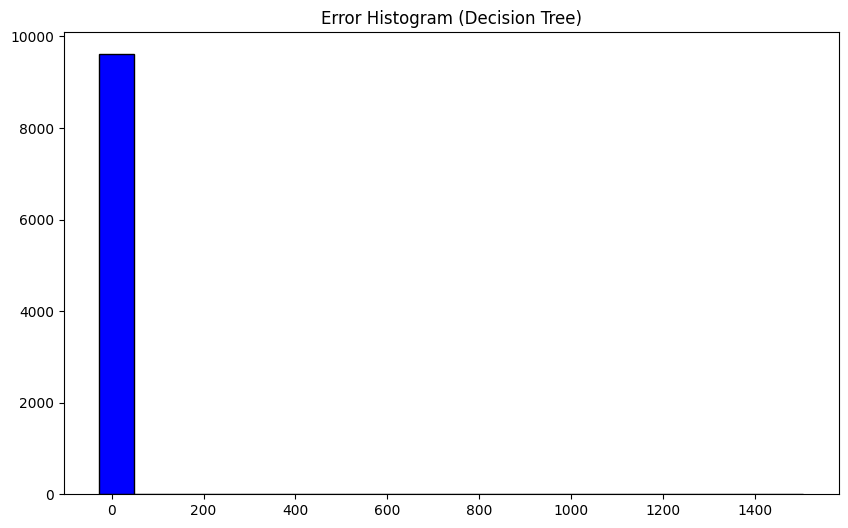

In [79]:
# Error Histogram for Decision Tree
plt.figure(figsize=(10,6))
plt.hist(y_test - tree_predictions, bins=20, color='blue', edgecolor='black')
plt.title('Error Histogram (Decision Tree)')
plt.show()

In [80]:
# 7. Building the App using Streamlit
st.title('Demand Forecasting for Top 10 Products')

2024-10-05 03:47:20.765 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:20.767 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [81]:
# Select Stock Code
stock_code_input = st.selectbox('Select Stock Code', top_10_quantity)

2024-10-05 03:47:35.038 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:35.044 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:35.049 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:35.054 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:35.057 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:35.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [82]:
# Input number of weeks
weeks_input = st.number_input('Enter number of weeks to forecast', min_value=1, max_value=15, value=15)

2024-10-05 03:47:51.125 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:51.133 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:51.136 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:51.138 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:51.141 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:47:51.145 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [83]:
# Display Forecast
if st.button('Forecast'):
    df_selected_stock = df[df['StockCode'] == stock_code_input]
    df_selected_stock = df_selected_stock.set_index('InvoiceDate').resample('W').agg({'Quantity': 'sum'})

    train_selected = df_selected_stock.iloc[:-weeks_input]
    test_selected = df_selected_stock.iloc[-weeks_input:]

    arima_model_selected = ARIMA(train_selected, order=(5, 1, 0))
    arima_result_selected = arima_model_selected.fit()

    forecast_selected = arima_result_selected.forecast(steps=weeks_input)

    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(train_selected.index, train_selected['Quantity'], label='Train')
    plt.plot(test_selected.index, test_selected['Quantity'], label='Test')
    plt.plot(test_selected.index, forecast_selected, label='Forecast', color='red')
    plt.legend()
    plt.title(f'ARIMA Forecast for Stock Code {stock_code_input}')
    st.pyplot(plt)


2024-10-05 03:48:08.484 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:48:08.494 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:48:08.500 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:48:08.505 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:48:08.510 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [84]:
# Download CSV
if st.button('Download CSV'):
    forecast_df = pd.DataFrame({'Week': test_selected.index, 'Forecast': forecast_selected})
    forecast_df.to_csv(f'{stock_code_input}_forecast.csv', index=False)
    st.write('CSV file downloaded successfully!')

2024-10-05 03:48:17.456 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:48:17.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:48:17.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:48:17.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-05 03:48:17.473 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
